#Импорты

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 8.7 MB/s 
     |████████████████████████████████| 482 kB 38.3 MB/s 
     |████████████████████████████████| 462 kB 59.8 MB/s 
     |████████████████████████████████| 41 kB 619 kB/s 


In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=381733a0c29a8fcbcd1d10d351e5538dc4a1c2fe19ff326e94207c17e033a363
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [ ]:
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from gensim.models import Word2Vec
from stellargraph.data import BiasedRandomWalk
import networkx as nx
import multiprocessing

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive')

#История про данные

Скопировать с курсовой 

Может взять новый датасет с майанимелист?

# Данные в виде графа

In [ ]:
anime = pd.read_csv('/content/gdrive/My Drive/anime.csv')
print(anime.columns)

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')


In [ ]:
rating = pd.read_csv('/content/gdrive/My Drive/rating.csv')
print(rating.columns)

Index(['user_id', 'anime_id', 'rating'], dtype='object')


Оставим понравившееся

In [ ]:
rating_liked = rating.drop(rating[rating['rating'].values < 5].index).drop(columns='rating')
rating_liked

,user_id,anime_id
47,1,8074
81,1,11617
83,1,11757
101,1,15451
153,2,11771
...,...,...
7813732,73515,16512
7813733,73515,17187
7813734,73515,22145
7813735,73516,790


Теперь нужно построить граф типа сор-таргет-веса для отправления в машинку по созданию графов

In [ ]:
similar_users = rating_liked[rating_liked.duplicated('anime_id', keep=False)].groupby('anime_id')['user_id'].apply(list).reset_index()
print(similar_users)

      anime_id                                            user_id
0            1  [19, 21, 23, 32, 34, 43, 46, 50, 51, 55, 68, 7...
1            5  [19, 21, 23, 51, 139, 152, 160, 200, 234, 242,...
2            6  [5, 17, 32, 41, 51, 55, 81, 97, 103, 108, 109,...
3            7  [160, 177, 277, 352, 646, 814, 1039, 1089, 117...
4            8  [296, 2515, 2812, 3127, 4738, 4749, 4930, 5016...
...        ...                                                ...
8739     34324  [3009, 13337, 13954, 22839, 31035, 40474, 4126...
8740     34325  [1734, 10194, 22835, 33519, 33915, 35370, 4241...
8741     34349                              [22434, 38503, 57620]
8742     34367                              [30565, 47765, 59643]
8743     34475                              [13954, 53492, 70547]

[8744 rows x 2 columns]


In [ ]:
anime = anime.dropna()

In [ ]:
for_merging = anime[['anime_id', 'name', 'type','genre']]
for_merging['attr'] = for_merging['name'] + ' '+ for_merging['type'] + ' ' + for_merging['genre']
for_merging = for_merging.drop(['name', 'type','genre'], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for_merging

,anime_id,attr
0,32281,"Kimi no Na wa. Movie Drama, Romance, School, S..."
1,5114,"Fullmetal Alchemist: Brotherhood TV Action, Ad..."
2,28977,"Gintama° TV Action, Comedy, Historical, Parody..."
3,9253,"Steins;Gate TV Sci-Fi, Thriller"
4,9969,"Gintama&#039; TV Action, Comedy, Historical, P..."
...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami O...
12290,5543,Under World OVA Hentai
12291,5621,Violence Gekiga David no Hoshi OVA Hentai
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...


In [ ]:
similar_users = similar_users.merge(for_merging, 
                        on=['anime_id'],
                        how='inner')
similar_users

,anime_id,user_id,attr
0,1,"[19, 21, 23, 32, 34, 43, 46, 50, 51, 55, 68, 7...","Cowboy Bebop TV Action, Adventure, Comedy, Dra..."
1,5,"[19, 21, 23, 51, 139, 152, 160, 200, 234, 242,...","Cowboy Bebop: Tengoku no Tobira Movie Action, ..."
2,6,"[5, 17, 32, 41, 51, 55, 81, 97, 103, 108, 109,...","Trigun TV Action, Comedy, Sci-Fi"
3,7,"[160, 177, 277, 352, 646, 814, 1039, 1089, 117...","Witch Hunter Robin TV Action, Drama, Magic, My..."
4,8,"[296, 2515, 2812, 3127, 4738, 4749, 4930, 5016...","Beet the Vandel Buster TV Adventure, Fantasy, ..."
...,...,...,...
8728,34324,"[3009, 13337, 13954, 22839, 31035, 40474, 4126...",Chiryokumaru ONA Action
8729,34325,"[1734, 10194, 22835, 33519, 33915, 35370, 4241...","Pokemon XY&amp;Z Specials Special Action, Adve..."
8730,34349,"[22434, 38503, 57620]","Diamond no Ace: Second Season OVA OVA Comedy, ..."
8731,34367,"[30565, 47765, 59643]","Long Riders Recap Special Comedy, Shounen, Sli..."


Сериал сравнивается с остальными сериалами (сразу в цикле пропускать нули сделать) по количеству общих пользователей - эти общие пользователи и есть веса

In [ ]:
graph = pd.DataFrame(data=similar_users).sample(n=800).reset_index().drop(columns=['index'])

In [ ]:
for_graph_weighted = {}

In [ ]:
k = 0
for i in range(1, 800):
  current_value = set(graph[graph.index == int(i-1)]['user_id'].values[0])
  for j in range(i, 800):
    compare_value = set(graph[graph.index == j]['user_id'].values[0])
    weight = len(current_value & compare_value)
    for_graph_weighted[k] = {'source': graph[graph.index == int(i-1)]['attr'].values[0], 'target': graph[graph.index == j]['attr'].values[0], 'weight': weight}
    k += 1

In [ ]:
data = pd.DataFrame.from_dict(for_graph_weighted).T
data = data.drop(data[data['weight'] == 0].index)
data['source'] = data['source'].astype(str)
data['target'] = data['target'].astype(str)
data['weight'] = data['weight'].astype(int)

In [ ]:
# compression_opts = dict(method='zip', archive_name='randsamp800.csv')
# data.to_csv('randsamp800.zip', index=False, compression=compression_opts)

Теперь разредим граф, отбросив веса меньше 50 пользователей

In [ ]:
data.shape

(194393, 3)

In [ ]:
data_fin = data.drop(data[data['weight'] <= 50].index)

In [ ]:
data_fin.shape

(20771, 3)

Сохраним названия сериалов, которые оказались в финальном датасете

In [ ]:
names_available = data_fin['source'].unique()

Создадим два одинаковых графа с помощью двух инструментов и посмотрим на них.

In [ ]:
graph_sg = StellarGraph(edges=data_fin, node_type_default="anime", edge_type_default="nusers_shared")

In [ ]:
graph_nx = nx.from_pandas_edgelist(data_fin, 'source', 'target', 'weight')

In [ ]:
print(graph_sg.info())

StellarGraph: Undirected multigraph
 Nodes: 399, Edges: 20771

 Node types:
  anime: [399]
    Features: none
    Edge types: anime-nusers_shared->anime

 Edge types:
    anime-nusers_shared->anime: [20771]
        Weights: range=[51, 12320], mean=246.678, std=443.671
        Features: none


In [ ]:
print(nx.info(graph_nx))

Graph with 399 nodes and 20771 edges


In [ ]:
data_fin[data_fin.weight == 1]

,source,target,weight


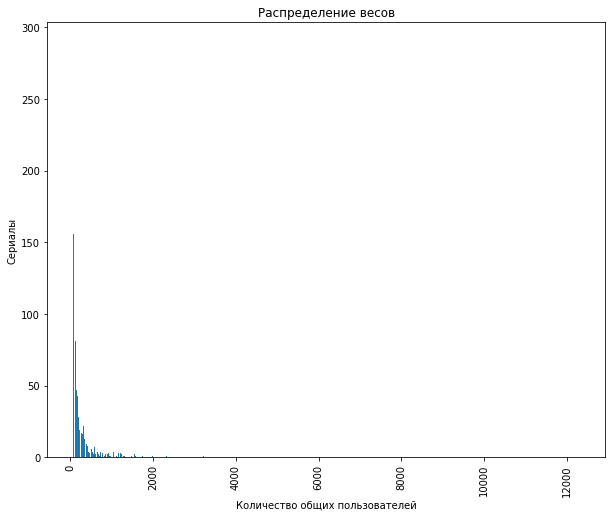

In [ ]:
names, weights = graph_sg.edges(include_edge_weight=True)

wt, cnt = np.unique(weights, return_counts=True)

plt.figure(figsize=(10, 8))
plt.bar(wt, cnt)
plt.title("Распределение весов")
plt.ylabel("Сериалы")
plt.xlabel("Количество общих пользователей")
plt.xticks(rotation=90)

plt.show()

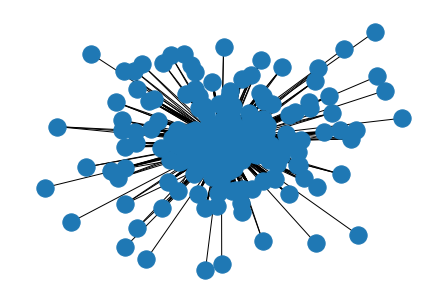

In [ ]:
nx.draw(graph_nx)

# Train Test (оставить пока)

## StellarGraph

In [ ]:
edge_splitter_test_sg = EdgeSplitter(graph_sg)
graph_test_sg, examples_test_sg, labels_test_sg = edge_splitter_test_sg.train_test_split(p=0.01, method="global")
print(graph_test_sg.info())

** Sampled 207 positive and 207 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 399, Edges: 20564

 Node types:
  anime: [399]
    Features: none
    Edge types: anime-nusers_shared->anime

 Edge types:
    anime-nusers_shared->anime: [20564]
        Weights: range=[51, 12320], mean=246.723, std=443.102
        Features: none


In [ ]:
edge_splitter_train_sg = EdgeSplitter(graph_test_sg, graph_sg)
graph_train_sg, examples_sg, labels_sg = edge_splitter_train_sg.train_test_split(p=0.01, method="global")
examples_train_sg, examples_model_selection_sg, labels_train_sg, labels_model_selection_sg = train_test_split(examples_sg, labels_sg, train_size=0.75, test_size=0.25)

print(graph_train_sg.info())

** Sampled 205 positive and 205 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 399, Edges: 20359

 Node types:
  anime: [399]
    Features: none
    Edge types: anime-nusers_shared->anime

 Edge types:
    anime-nusers_shared->anime: [20359]
        Weights: range=[51, 12320], mean=246.478, std=443.213
        Features: none


In [ ]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train_sg),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection_sg),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test_sg),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,307,Train Graph,Test Graph,Train the Link Classifier
Model Selection,103,Train Graph,Test Graph,Select the best Link Classifier model
Test set,414,Test Graph,Full Graph,Evaluate the best Link Classifier


In [ ]:
# for_test = pd.DataFrame(data=similar_users)[-200:]
# for_graph_weighted = {}
# k = 0
# for i in range(8534, 8733):
#   current_value = set(for_test[for_test.index == int(i-1)]['user_id'].values[0])
#   for j in range(i, 8733):
#     compare_value = set(for_test[for_test.index == j]['user_id'].values[0])
#     weight = len(current_value & compare_value)
#     for_graph_weighted[k] = {'source': for_test[for_test.index == int(i-1)]['attr'].values[0], 'target': for_test[for_test.index == j]['attr'].values[0], 'weight': weight}
#     k += 1

# data_test = pd.DataFrame.from_dict(for_graph_weighted).T
# data_test = data_test.drop(data_test[data_test['weight'] == 0].index)
# data_test['source'] = data_test['source'].astype(str)
# data_test['target'] = data_test['target'].astype(str)
# data_test['weight'] = data_test['weight'].astype(int)

# graph_nx_test = nx.from_pandas_edgelist(data_test, 'source', 'target', 'weight')

## NetworkX

https://stackoverflow.com/questions/53255889/test-train-data-set-for-graph-network

In [ ]:
edge_splitter_test_nx = EdgeSplitter(graph_nx)
graph_test_nx, examples_test_nx, labels_test_nx = edge_splitter_test_nx.train_test_split(p=0.01, method="global")

print(nx.info(graph_test_nx))

** Sampled 207 positive and 207 negative edges. **
Graph with 399 nodes and 20564 edges


In [ ]:
edge_splitter_train_nx = EdgeSplitter(graph_test_nx, graph_nx)
graph_train_nx, examples_nx, labels_nx = edge_splitter_train_nx.train_test_split(p=0.01, method="global")
examples_train_nx, examples_model_selection_nx, labels_train_nx, labels_model_selection_nx = train_test_split(examples_nx, labels_nx, train_size=0.75, test_size=0.25)

print(nx.info(graph_train_nx))

** Sampled 205 positive and 205 negative edges. **
Graph with 399 nodes and 20359 edges


In [ ]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train_nx),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection_nx),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test_nx),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,307,Train Graph,Test Graph,Train the Link Classifier
Model Selection,103,Train Graph,Test Graph,Select the best Link Classifier model
Test set,414,Test Graph,Full Graph,Evaluate the best Link Classifier


# Эмбеддинги

## word2vec и stellargraph

Можно поделать нод2век со стеллариграфом, через ворд2век

In [ ]:
rw = BiasedRandomWalk(graph_train_sg)
weighted_walks = rw.run(
    nodes=graph_train_sg.nodes(),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 3990


In [ ]:
weighted_model = Word2Vec(weighted_walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=1)
weighted_node_embeddings = weighted_model.wv.vectors

Нарисуем с помощью T-SNE

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(embedding_train)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


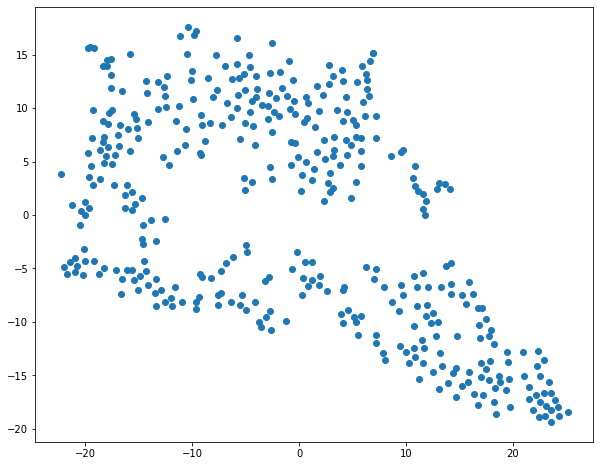

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(weighted_node_embeddings_2d[:, 0], weighted_node_embeddings_2d[:, 1])
plt.show()

In [ ]:
for node, score in weighted_model.wv.most_similar('Sonic X TV Adventure, Comedy, Kids, Mecha, Sci-Fi, Shounen'):
  print(node, score)

K-On!: Ura-On! Special Comedy 0.2380547970533371
Piano TV Drama, Music, Romance, Shoujo, Slice of Life 0.22983455657958984
Berserk (2016) TV Action, Adventure, Demons, Drama, Fantasy, Horror, Military, Romance, Seinen, Supernatural 0.20040269196033478
Hidamari Sketch TV Comedy, School, Slice of Life 0.19388286769390106
Inugami-san to Nekoyama-san TV Comedy, School, Shoujo Ai 0.18680253624916077
Uta Kata Special Special Drama, Magic 0.1858973354101181
Lupin III: Kutabare! Nostradamus Movie Action, Adventure, Comedy, Shounen 0.1803009808063507
Dragon Ball Z Movie 09: Ginga Girigiri!! Bucchigiri no Sugoi Yatsu Movie Adventure, Comedy, Fantasy, Sci-Fi, Shounen 0.17223413288593292
Boku wa Tomodachi ga Sukunai TV Comedy, Ecchi, Harem, Romance, School, Seinen, Slice of Life 0.16096721589565277
Bakuten Shoot Beyblade TV Action, Adventure, Comedy, Sci-Fi, Shounen, Sports 0.16039153933525085


## Теперь нод2век

In [ ]:
node2vec = Node2Vec(graph_train_nx, dimensions=20, walk_length=16, num_walks=10, weight_key='weight')
model = node2vec.fit(window=3, min_count=1)

Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


In [ ]:
ne = model.wv.vectors
tsne2 = TSNE(n_components=2, random_state=42)
ne_2d = tsne2.fit_transform(ne)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


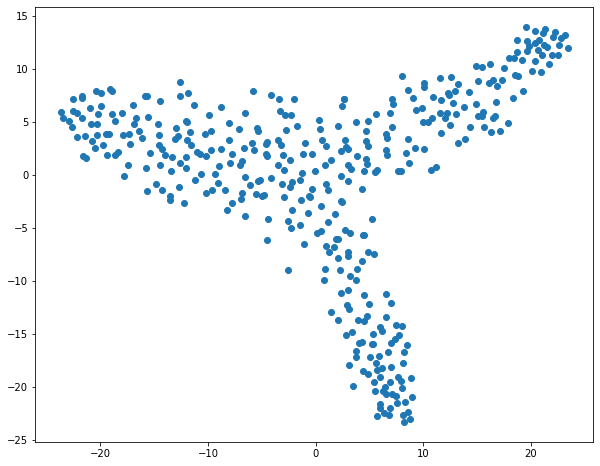

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(ne_2d[:, 0], ne_2d[:, 1])
plt.show()

In [ ]:
print(names_available[306], model.wv.get_vector(names_available[306]))

Itazura na Kiss TV Comedy, Romance, Shoujo [ 0.1755846   0.4491189  -0.15342526  0.09179346 -0.2462004  -0.5903818
 -0.05189431  0.06390037  0.09802115 -0.01817974  0.24985453 -0.19448137
  0.12248823 -0.12252805 -0.05603335 -0.04450704  0.78883237  0.31132117
 -0.02152587  0.2577461 ]


In [ ]:
for node, score in model.wv.most_similar('Sonic X TV Adventure, Comedy, Kids, Mecha, Sci-Fi, Shounen'):
  print(node, score)

Mezzo DSA TV Action, Adventure, Comedy, Mystery, Sci-Fi 0.997641921043396
Dragon Ball: Super Saiya-jin Zetsumetsu Keikaku OVA Adventure, Fantasy, Martial Arts, Sci-Fi, Shounen, Super Power 0.9974629282951355
3x3 Eyes OVA Action, Demons, Fantasy, Horror, Romance 0.9973310232162476
Maria-sama ga Miteru 3rd OVA Drama, School, Shoujo Ai, Slice of Life 0.9973295331001282
Piano TV Drama, Music, Romance, Shoujo, Slice of Life 0.9967692494392395
Iriya no Sora, UFO no Natsu OVA Drama, Romance, Sci-Fi 0.9967077374458313
Waga Seishun no Arcadia Movie Action, Adventure, Drama, Sci-Fi, Space 0.9966886043548584
Amaenaide yo!! Katsu!! TV Comedy, Ecchi, Harem, Romance, Supernatural 0.9965972900390625
Code Geass: Hangyaku no Lelouch TV Action, Mecha, Military, School, Sci-Fi, Super Power 0.9965381622314453
Rose of Versailles TV Adventure, Drama, Historical, Romance, Shoujo 0.9965096712112427


# Классификация

In [ ]:
arr = []
for i in examples_train_nx[:5]:
  a, b = i
  arr.append(model.wv.get_vector(a))
  arr.append(model.wv.get_vector(b))


In [ ]:
data_tuples = list(zip(examples_train_nx, labels_train_nx))

In [ ]:
df = pd.DataFrame(data_tuples, columns=['features', 'labels'])

In [ ]:
features = []
for i in df.features:
  a, b = i
  features.append(a + ' ' + b)

In [ ]:
df.features = features
df

,features,labels
0,Aa! Megami-sama!: Chichaitte Koto wa Benri da ...,1
1,"Shonan Junai Gumi! OVA Action, Comedy, School ...",0
2,"Magic Knight Rayearth II TV Adventure, Drama, ...",1
3,Kara no Kyoukai 7: Satsujin Kousatsu (Kou) Mov...,0
4,"Junketsu no Maria TV Comedy, Fantasy, Historic...",1
...,...,...
302,Fate/kaleid liner Prisma☆Illya 2wei Herz! TV A...,1
303,"Ansatsu Kyoushitsu (TV) 2nd Season TV Action, ...",0
304,"Noblesse: Awakening ONA Action, School, Supern...",0
305,"One More Time, One More Chance Music Drama, Mu...",0


In [ ]:
df

,features,labels
0,[Aa! Megami-sama!: Chichaitte Koto wa Benri da...,1
1,"[Shonan Junai Gumi! OVA Action, Comedy, School...",0
2,"[Magic Knight Rayearth II TV Adventure, Drama,...",1
3,[Kara no Kyoukai 7: Satsujin Kousatsu (Kou) Mo...,0
4,"[Junketsu no Maria TV Comedy, Fantasy, Histori...",1
...,...,...
302,[Fate/kaleid liner Prisma☆Illya 2wei Herz! TV ...,1
303,"[Ansatsu Kyoushitsu (TV) 2nd Season TV Action,...",0
304,"[Noblesse: Awakening ONA Action, School, Super...",0
305,"[One More Time, One More Chance Music Drama, M...",0


In [ ]:
emb = Word2Vec(sentences=df.features)

# Оценка модели